In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

seed = 42
np.random.seed(seed)

### Set defaults for plots

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'

sns.set_style("whitegrid", rc={"figure.figsize": (12, 8)})
sns.set_palette("colorblind")

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGE_FLDR = "eda"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", IMAGE_FLDR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### Load the data

In [100]:
#open the locally saved csv
df = pd.read_csv('data/mgm.csv', usecols=['description', 'jobtype', 'usetype'])

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17514 entries, 0 to 17513
Data columns (total 3 columns):
description    17514 non-null object
jobtype        17514 non-null object
usetype        17514 non-null object
dtypes: object(3)
memory usage: 410.6+ KB


In [102]:
df = df[df.usetype != 'Mixed Occupancy']

In [103]:
X = df['description']
y = df['usetype']
z = df['jobtype']

In [104]:
y = y.map({'Commercial': 0, 'Residential': 1})
z = z.map({'New': 0, 'Existing': 1, 'Alteration': 2, 'Repair': 3, 'Other': 4, 'Addition': 5})

In [105]:
y.value_counts(), z.value_counts()

(1    10381
 0     7113
 Name: usetype, dtype: int64, 0    4802
 1    3942
 2    3058
 3    2302
 4    2255
 5    1135
 Name: jobtype, dtype: int64)

### Feature engineering

In [106]:
y_bin = label_binarize(y, classes=[0,1])
n_y_bin_classes = y_bin.shape[1]
z_bin = label_binarize(z, classes=[0,1,2,3,4,5])
n_z_bin_classes = z_bin.shape[1]

In [107]:
n_y_bin_classes

1

In [108]:
X_tr, X_te, y_tr, y_te, = train_test_split(X, y, test_size=0.20, random_state=42)

In [109]:
# create the BOW representation
bow_transform = text.CountVectorizer(min_df=0, 
                                     stop_words="english", 
                                     ngram_range=(1, 3))
X_tr_bow = bow_transform.fit_transform(X_tr)
X_te_bow = bow_transform.transform(X_te)

matrix_len = len(bow_transform.vocabulary_)
matrix_len

89674

In [110]:
#create tf-idf representation using the bow matrix
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_trfm.transform(X_te_bow)
X_te_tfidf.shape

(3499, 89674)

### Instantiate a random forest classifier, run on the target variables and score the model

In [111]:
#instantiate the classifier
rf = RandomForestClassifier(random_state=seed)

In [112]:
rf.fit(X_tr_tfidf, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [113]:
y_pred = rf.predict(X_te_tfidf)
print(rf.__class__.__name__, accuracy_score(y_te, y_pred))

RandomForestClassifier 0.9937124892826522


In [114]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("StDev:", scores.std())

In [115]:
y_tr_tfidf_scores = cross_val_score(rf, X_tr_tfidf, y_tr, cv=10, scoring="accuracy")

In [116]:
display_scores(y_tr_tfidf_scores)

Scores: [0.99       0.99428571 0.99571429 0.99571429 0.99571429 0.98714286
 0.99357143 0.99642602 0.99713877 0.98712446]
Mean: 0.9932832108917833
StDev: 0.00360519926880129


In [117]:
y_te_tfidf_scores = cross_val_score(rf, X_te_tfidf, y_te, cv=10, scoring="accuracy")

In [118]:
display_scores(y_te_tfidf_scores)

Scores: [0.97720798 0.97435897 0.98860399 0.98005698 0.98       0.97421203
 0.96848138 0.98853868 0.98567335 0.97994269]
Mean: 0.9797076057763736
StDev: 0.006197354639599046


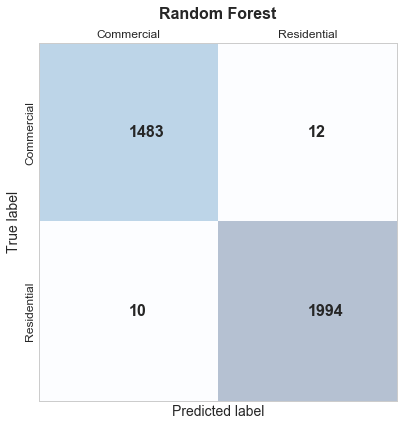

Saving figure random_forest_conf_matrix


In [120]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
confmat_y = confusion_matrix(y_te, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_y, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_y.shape[0]):
    for j in range(confmat_y.shape[1]):
        ax.text(x=j, y=i, s=confmat_y[i, j], va='center', fontdict={'fontsize': 16,'fontweight': 'bold'})
plt.title('Random Forest')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['Commercial', 'Residential'])
plt.yticks([0, 1], ['Commercial', 'Residential'], rotation='vertical', va='center')
ax.grid(False)
plt.tight_layout()
plt.show()
save_fig("random_forest_conf_matrix")

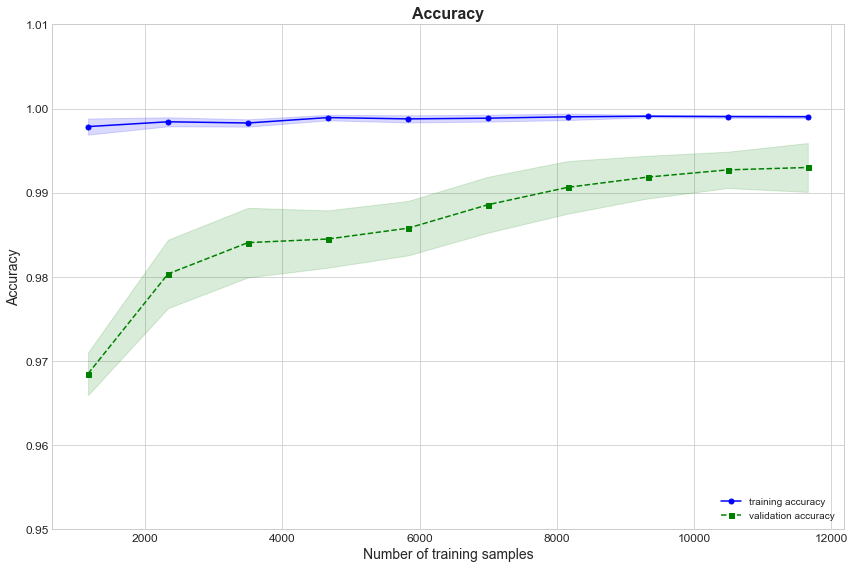

Saving figure random_forest_accuracy


In [23]:
# Plot a learning curve chart
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=rf,
                               X=X_tr_tfidf,
                               y=y_tr,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=6,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.title('Accuracy')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.95, 1.01])
plt.tight_layout()
plt.show()
save_fig("random_forest_accuracy")

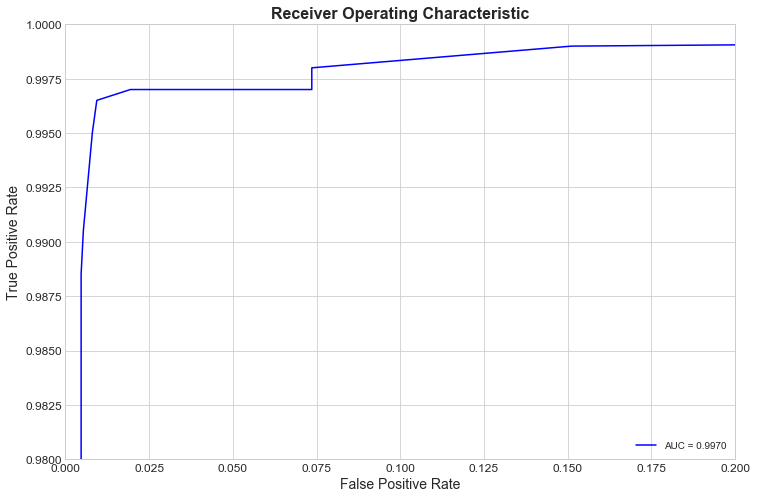

Saving figure logistic_roc_curve


In [24]:
from sklearn.metrics import accuracy_score, roc_curve, auc
probs = rf.predict_proba(X_te_tfidf)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_te, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0, 0.2)
plt.ylim(0.98, 1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
save_fig("logistic_roc_curve")

In [ ]:
import urllib
from sodapy import Socrata

#grab the data from the city's open data portal
client = Socrata("data.montgomeryal.gov", None)
results = client.get(dataset_identifier="7uyp-bn27", limit=99999, select=["Description, UseType, IssuedDate"], where="IssuedDate between '2018-05-01T12:00:00' and '2018-06-15T12:00:00'")
raw_data = pd.DataFrame.from_records(results)

#create copy of raw_data as df_new
df_new = raw_data.sort_index()
X_new = df_new['Description']
y_new = df_new['UseType']
y_new = y_new.map({'Commercial': 0, 'Residential': 1})
y_new_bin = label_binarize(y_new, classes=[0,1])
n_y_new_bin_classes = y_new_bin.shape[1]
print(n_y_new_bin_classes)

# Transform new description data to tf-idf representation
X_new_bow = bow_transform.transform(X_new)
X_new_tfidf = tfidf_trfm.transform(X_new_bow)
X_new_tfidf.shape

# Employ the model to make predictions on new data
y_new_pred = tuned.predict(X_new_tfidf)

y_new_pred_classes = []
for i in y_new_pred:
    if i > .5:
        y_new_pred_classes.append(1)
    else:
        y_new_pred_classes.append(0)
        
# Plot the confusion matrix
confmat_y = confusion_matrix(y_new, y_new_pred_classes)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_y, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_y.shape[0]):
    for j in range(confmat_y.shape[1]):
        ax.text(x=j, y=i, s=confmat_y[i, j], va='center', ha='center')

plt.title('Confusion Matrix of Predictions on New Data')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['Commercial', 'Residential'])
plt.yticks([0, 1], ['Commercial', 'Residential'], rotation='vertical', va='center')
ax.grid(False)
plt.tight_layout()
plt.show()
save_fig("new_predictions_confusion_matrix")

### Create a deep learning model with keras and compare to the random forest

In [25]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [26]:
model = Sequential()

In [27]:
model.add(Dense(100, input_dim=matrix_len, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(100, input_dim=matrix_len, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1, input_dim=matrix_len, kernel_initializer='uniform', activation='sigmoid'))

In [28]:
model.output_shape

(None, 1)

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               8967500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 8,977,701
Trainable params: 8,977,701
Non-trainable params: 0
_________________________________________________________________


In [30]:
opt = Adam(lr=0.0001)

In [31]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
early_stopping_monitor = EarlyStopping(monitor='acc', min_delta=0.00001, patience=2, verbose=1)

In [33]:
history = model.fit(X_tr_tfidf, y_tr, batch_size=32, epochs=25, verbose=1, validation_data=(X_te_tfidf, y_te))

Train on 13995 samples, validate on 3499 samples
Epoch 1/25
13995/13995 [==============================] - 205s 15ms/step - loss: 0.2167 - acc: 0.9375 - val_loss: 0.0523 - val_acc: 0.9886
Epoch 2/25
13995/13995 [==============================] - 187s 13ms/step - loss: 0.0290 - acc: 0.9932 - val_loss: 0.0368 - val_acc: 0.9929
Epoch 3/25
13995/13995 [==============================] - 178s 13ms/step - loss: 0.0130 - acc: 0.9973 - val_loss: 0.0326 - val_acc: 0.9940
Epoch 4/25
13995/13995 [==============================] - 178s 13ms/step - loss: 0.0066 - acc: 0.9981 - val_loss: 0.0306 - val_acc: 0.9946
Epoch 5/25
13995/13995 [==============================] - 184s 13ms/step - loss: 0.0040 - acc: 0.9989 - val_loss: 0.0326 - val_acc: 0.9940
Epoch 6/25
13995/13995 [==============================] - 177s 13ms/step - loss: 0.0029 - acc: 0.9994 - val_loss: 0.0325 - val_acc: 0.9940
Epoch 7/25
13995/13995 [==============================] - 191s 14ms/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0

In [59]:
score, acc = model.evaluate(X_te_tfidf, y_te, batch_size=32)

3499/3499 [==============================] - 6s 2ms/step


In [60]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.045266396396767376
Test accuracy: 0.9934266934261284


In [35]:
y_pred = model.predict(X_te_tfidf, batch_size=32)

In [36]:
y_pred_classes = []
for i in y_pred:
    if i > .5:
        y_pred_classes.append(1)
    else:
        y_pred_classes.append(0)

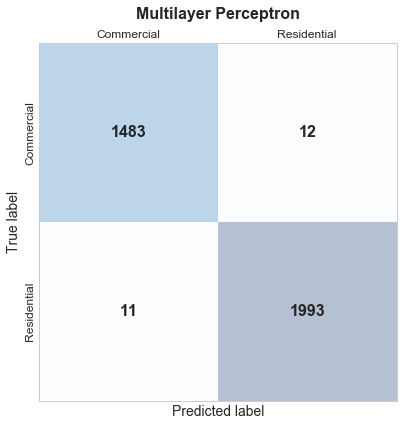

Saving figure mlp_confusion_matrix


In [90]:
# Plot the confusion matrix
confmat_y = confusion_matrix(y_te, y_pred_classes)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_y, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_y.shape[0]):
    for j in range(confmat_y.shape[1]):
        ax.text(x=j, y=i, s=confmat_y[i, j], va='center', ha='center', fontdict={'fontsize': 16,'fontweight': 'bold'})
plt.title('Multilayer Perceptron')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['Commercial', 'Residential'])
plt.yticks([0, 1], ['Commercial', 'Residential'], rotation='vertical', va='center')
ax.grid(False)
plt.tight_layout()
plt.show()
save_fig("mlp_confusion_matrix")

### Compare the models

In [38]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_te_tfidf).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_te, y_pred_keras)

In [39]:
y_pred_keras = model.predict(X_te_tfidf, batch_size=32).ravel()

In [40]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_te, y_pred_keras)

In [41]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [42]:
y_pred_rf = rf.predict_proba(X_te_tfidf)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_te, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

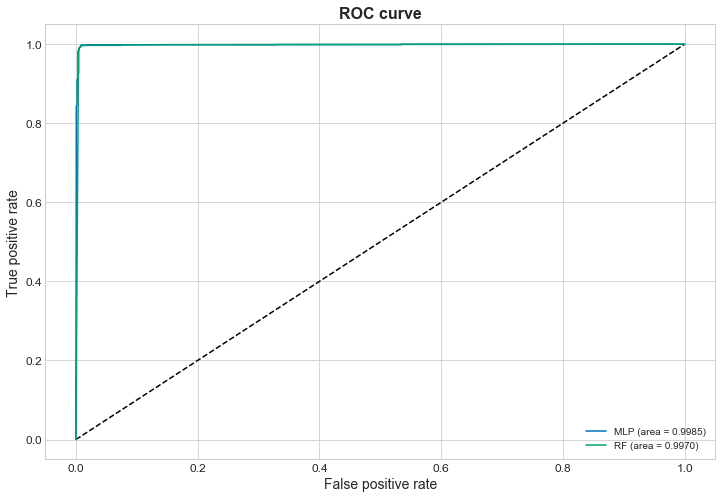

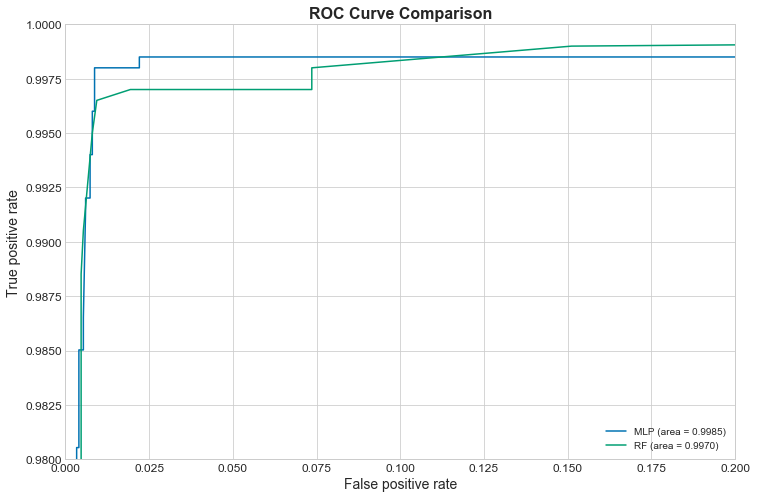

Saving figure roc_curve_comparison


In [43]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='MLP (area = {:.4f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.4f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.98, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='MLP (area = {:.4f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.4f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()
save_fig("roc_curve_comparison")

In [44]:
### ROC curve for MLP

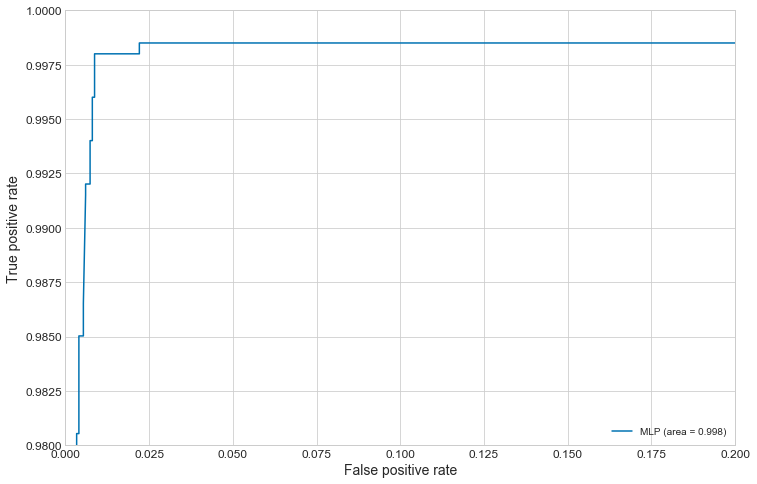

In [45]:
### ROC curve for MLP
plt.xlim(0, 0.2)
plt.ylim(0.98, 1)
plt.plot(fpr_keras, tpr_keras, label='MLP (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

### Convert predictions to text labels and join with the main dataframe to see where the errors occurred 

In [46]:
real_v_pred = pd.concat([y_te.reset_index(), pd.Series(y_pred_classes)], axis=1, join='inner', ignore_index=True).reset_index(drop=True).set_index([1])

In [47]:
real_v_pred.reset_index(inplace=True)
real_v_pred.columns = ['test', 'index', 'pred']

In [48]:
errors = real_v_pred[real_v_pred.test != real_v_pred.pred]
errors.set_index(keys='index', inplace=True)

In [49]:
df_errors = df.join(errors, how='inner')

### Descriptions of where 'Residential' was misclassified

In [50]:
for row in df_errors['description'][df_errors.usetype == 'Residential']:
    print("-", row)

- replace 3'6''x16' cabinet on existing pole sign and add a 5'3''x 10'3'' electronic message cabinet on same existing pole sign. sign to be registered with nationally recognized testing labs. electrical permit required. all applicable department inspections as required. to meet all applicable codes.
- replace 3'6''x16' cabinet on existing pole sign and add a 5'3''x 10'3'' electronic message cabinet on same existing pole sign. sign to be registered with nationally recognized testing labs. electrical permit required. all applicable department inspections as required. to meet all applicable codes.
- GRADING PERMIT TO ERECT  TWO STORY  SINGLE FAMILY RESIDENCE WITH 5462 SF TOTAL. PROPERTY NOT IN A PRIORITY CONSTRUCTION SITE. MUST COMPLY WITH CITY’S GUIDELINES.  TO MEET ALL APPLICABLE CODES.
- REMOVING EXISTING POOL AND REINSTALL WITH ALL NEW ELECTRIAL. ALL APPLICABLE DEPARTMENT INSPECTIONS AS REQUIRED. TO MEET ALL APPLICABLE CODES.
- GENERAL REPAIRS TO REPLACE WOOD FOR ROOFING. APPROVAL PER

### Descriptions of where 'Commercial' was misclassified

In [51]:
for row in df_errors['description'][df_errors.usetype == 'Commercial']:
    print("-", row)

- GRADING PERMIT FOR PREP WORK OF NEW APARTMENT BUILDING. THIS IS NOT A PRIORITY SITE. NPDES APPLIED FOR. ENGINEERING APPROVAL ON FILE. BOND #19040. TO MEET ALL APPLICABLE CODES. **NO FEE PERMIT***
- DEMOLISH EXISTING WOOD FRAME DWELLING TO CLEAR LOT. HEALTH DEPT APPROVAL ON FILE. WATER WORKS NO. 5076. BOND NO. 321729. DEMOLITION MUST BE COMPLETED WITHIN 30 DAYS. FINAL INSPECTION WILL BE REQUIRED BY HOUSING CODES AND WATER WORKS. TO MEET ALL APPLICABLE CODES.
- DEMOLISH EXISTING WOOD FRAME DWELLING TO CLEAR LOT. HEALTH DEPT APPROVAL ON FILE. WATER WORKS NO. 5076. BOND NO. 321729. DEMOLITION MUST BE COMPLETED WITHIN 30 DAYS. FINAL INSPECTION WILL BE REQUIRED BY HOUSING CODES AND WATER WORKS. TO MEET ALL APPLICABLE CODES.
- RENOVATIONS TO INTERIOR OF EXISTING APARTMENTS UNITS 209 & 211. DUE TO FIRE DAMAGE. WILL NEED FRAMING AND ELECTRICAL INSPECTIONS. ALL APPLICABLE DEPARTMENT INSPECTIONS AS REQUIRED. MUST COMPLY WITH STATE ENERGY CODE. TO MEET ALL APPLICABLE CODES.
- RENOVATIONS TO INTE

### Download new permit data, predict the class and score results

In [52]:
import urllib
from sodapy import Socrata
#grab the data from the city's open data portal
client = Socrata("data.montgomeryal.gov", None)
results = client.get(dataset_identifier="7uyp-bn27", limit=99999, select=["Description, UseType, IssuedDate"], where="IssuedDate between '2018-05-01T12:00:00' and '2018-06-15T12:00:00'")
raw_data = pd.DataFrame.from_records(results)
#create copy of raw_data as df_new
df_new = raw_data.sort_index()
X_new = df_new['Description']
y_new = df_new['UseType']
y_new = y_new.map({'Commercial': 0, 'Residential': 1})
y_new_bin = label_binarize(y_new, classes=[0,1])
n_y_new_bin_classes = y_new_bin.shape[1]
print(n_y_new_bin_classes)

1


In [53]:
# Transform new description data to tf-idf representation
X_new_bow = bow_transform.transform(X_new)
X_new_tfidf = tfidf_trfm.transform(X_new_bow)
X_new_tfidf.shape

(1052, 89674)

In [62]:
score, acc = model.evaluate(X_new_tfidf, y_new, batch_size=32)

1052/1052 [==============================] - 2s 2ms/step


In [63]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.09068782785021962
Test accuracy: 0.9847908745247148


In [92]:
# Employ the model to make predictions on new data
y_new_pred = model.predict(X_new_tfidf, batch_size=32)

In [93]:
y_new_pred_classes = []
for i in y_new_pred:
    if i > .5:
        y_new_pred_classes.append(1)
    else:
        y_new_pred_classes.append(0)

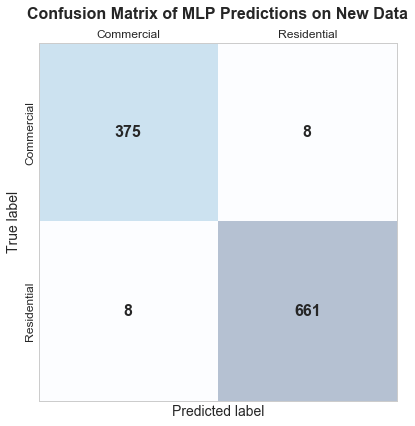

Saving figure new_predictions_confusion_matrix


In [94]:
# Plot the confusion matrix
confmat_y = confusion_matrix(y_new, y_new_pred_classes)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_y, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_y.shape[0]):
    for j in range(confmat_y.shape[1]):
        ax.text(x=j, y=i, s=confmat_y[i, j], va='center', ha='center', fontdict={'fontsize': 16,'fontweight': 'bold'})

plt.title('Confusion Matrix of MLP Predictions on New Data')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['Commercial', 'Residential'])
plt.yticks([0, 1], ['Commercial', 'Residential'], rotation='vertical', va='center')
ax.grid(False)
plt.tight_layout()
plt.show()
save_fig("new_predictions_confusion_matrix")

In [85]:
y_new_pred = rf.predict(X_new_tfidf)
print(rf.__class__.__name__, accuracy_score(y_new, y_new_pred))

RandomForestClassifier 0.9771863117870723


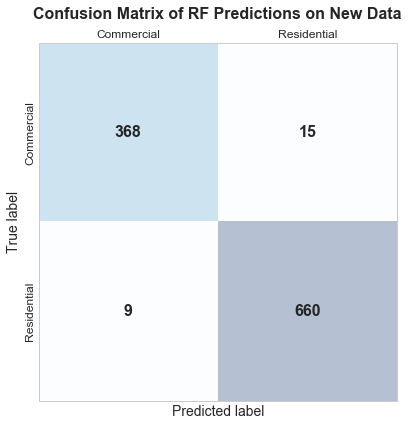

Saving figure new_predictions_confusion_matrix


In [121]:
# Plot the confusion matrix
confmat_y = confusion_matrix(y_new, y_new_pred_rf)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat_y, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_y.shape[0]):
    for j in range(confmat_y.shape[1]):
        ax.text(x=j, y=i, s=confmat_y[i, j], va='center', ha='center', fontdict={'fontsize': 16,'fontweight': 'bold'})

plt.title('Confusion Matrix of RF Predictions on New Data')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['Commercial', 'Residential'])
plt.yticks([0, 1], ['Commercial', 'Residential'], rotation='vertical', va='center')
ax.grid(False)
plt.tight_layout()
plt.show()
save_fig("new_predictions_confusion_matrix")

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


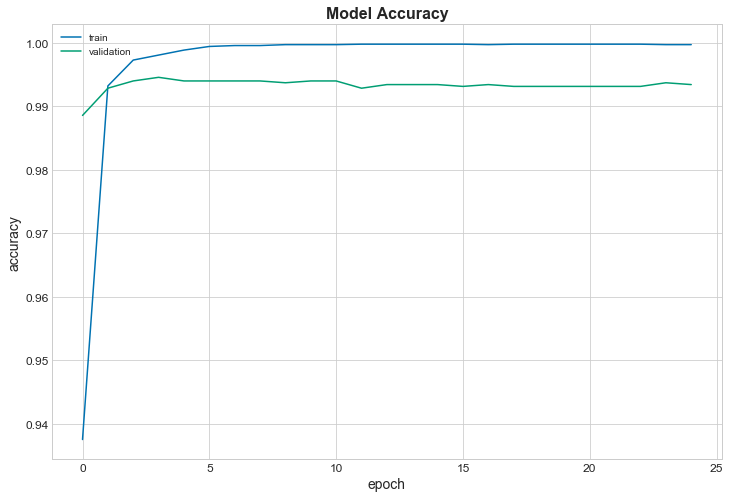

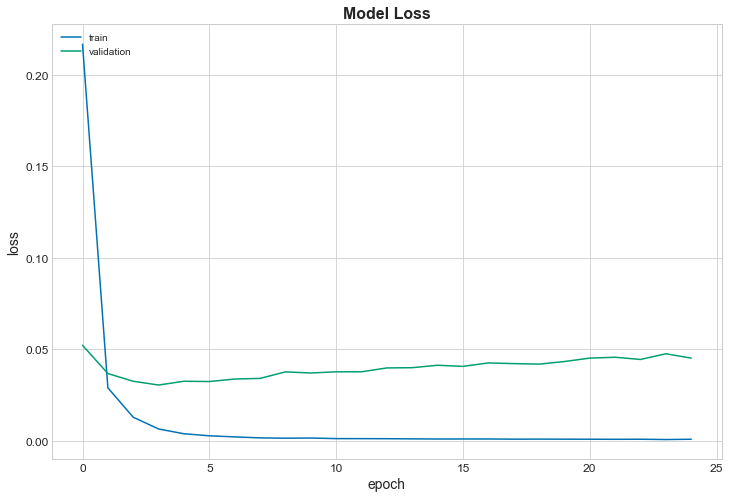

In [57]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()